# Preparing Data

## Import Library and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The following describes the dataset columns:

```
crim - per capita crime rate by town
zn - proportion of residential land zoned for lots over 25,000 sq.ft.
indus - proportion of non-retail business acres per town.
chas - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
nox - nitric oxides concentration (parts per 10 million)
rm - average number of rooms per dwelling
age - proportion of owner-occupied units built prior to 1940
dis - weighted distances to five Boston employment centres
rad - index of accessibility to radial highways
tax - full-value property-tax rate per $10,000
ptratio - pupil-teacher ratio by town
black - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
lstat - % lower status of the population
medv - Median value of owner-occupied homes in $1000's
```



In [2]:
df = pd.read_csv('boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


## Pre Processing dan Split Data

In [4]:
# Duplicate value
print(f'Total duplicate value: {df.duplicated().sum()}')

Total duplicate value: 0


In [5]:
# Invalid and missing values
missing_df = pd.DataFrame({'Data Type': df.dtypes, 'Missing Count': df.isnull().sum(), 'Missing Percentage': (df.isnull().sum() / len(df)) * 100}).sort_values(by='Missing Count', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] != 0]
missing_df = missing_df.style.format({'Missing Percentage': '{:.2f}%'})
display(missing_df)

,Data Type,Missing Count,Missing Percentage


In [6]:
# Split train test
from sklearn.model_selection import train_test_split

X = df.drop(columns='medv')
y = df[['medv']]

# First splitting: train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((404, 13), (102, 13))

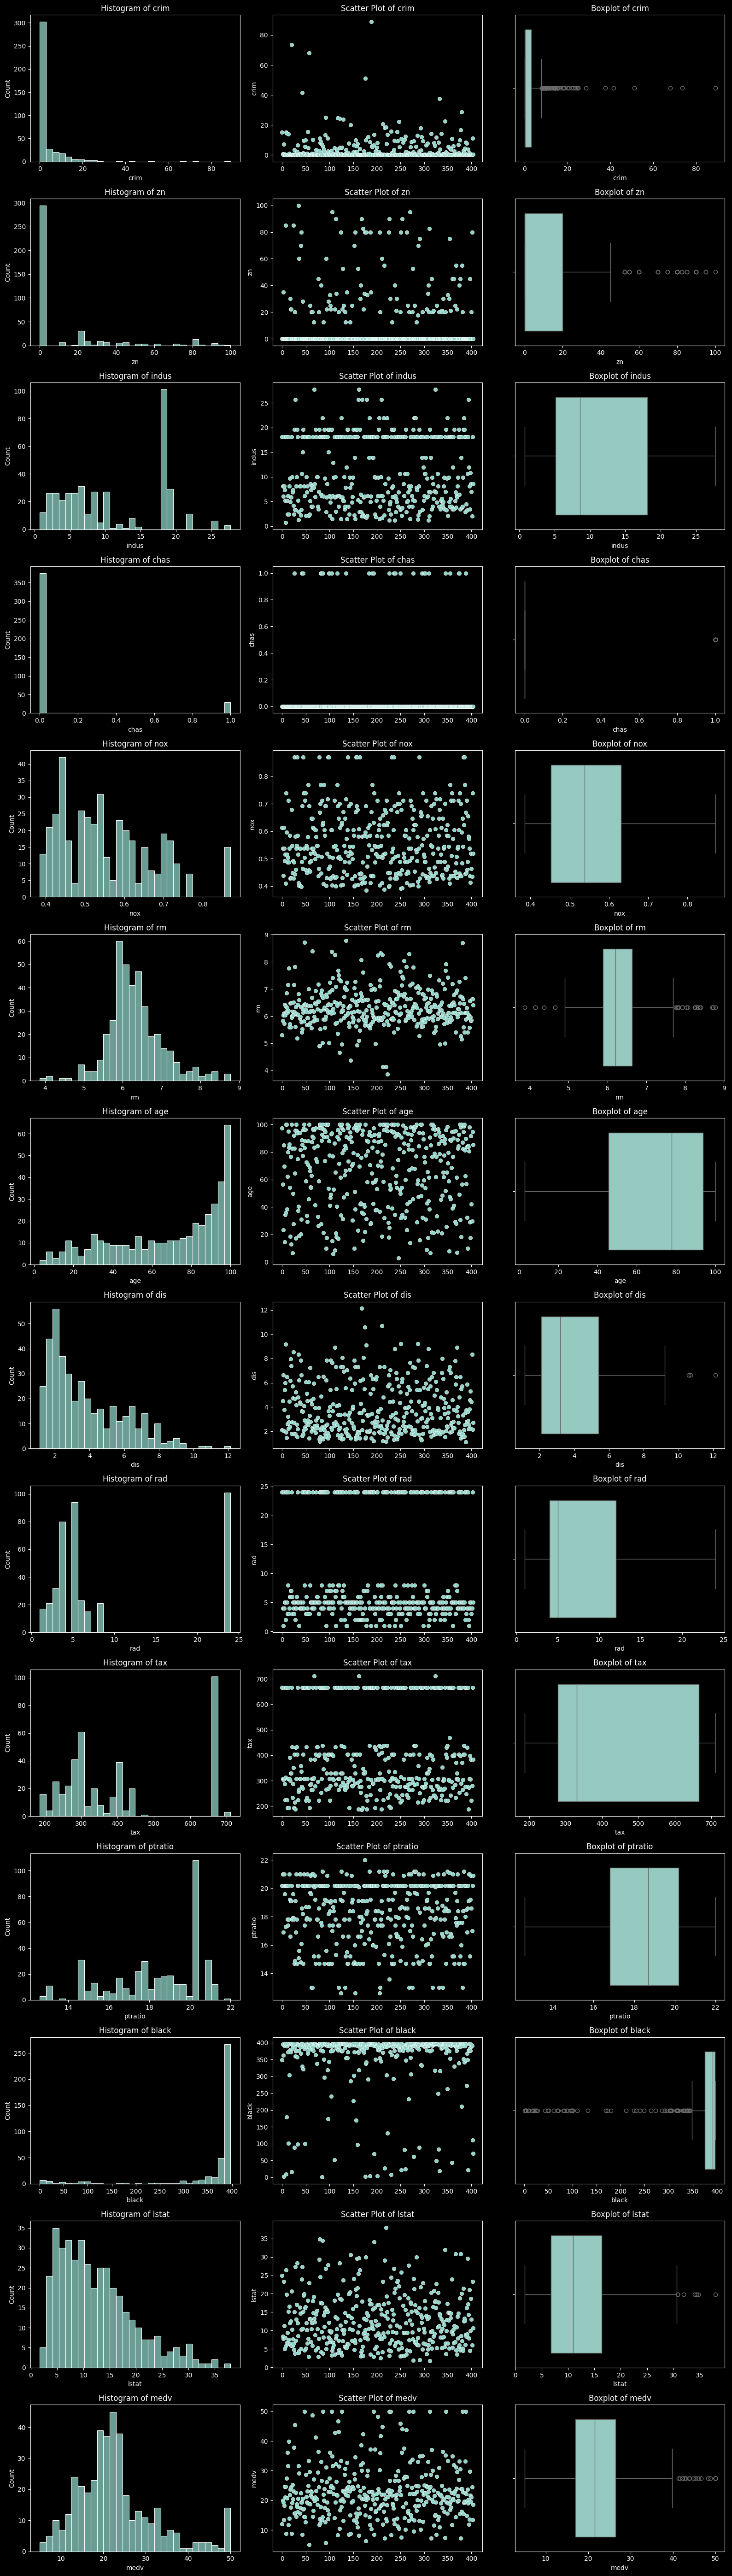

In [8]:
# Outlier

def distribution_plot(data, variable):
  fig, axes = plt.subplots(nrows=len(variable), ncols=3, figsize=(16,4*len(variable)))
  plt.style.use('dark_background')
  for i in range(0, len(variable)):
    # Histogram
    sns.histplot(data[variable[i]], bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {variable[i]}")
    # Sctter plot
    sns.scatterplot(x=range(len(data[variable[i]])), y=data[variable[i]], ax=axes[i, 1])
    axes[i, 1].set_title(f"Scatter Plot of {variable[i]}")
    # Box plot
    sns.boxplot(data[variable[i]], orient='h', ax=axes[i, 2])
    axes[i, 2].set_title(f"Boxplot of {variable[i]}")
  plt.tight_layout()
  plt.show()

df_train = pd.concat([X_train, y_train], axis=1)
variable = df_train.select_dtypes(include='number').columns
distribution_plot(df_train, variable)

In [11]:
# Handling missing value
df_train = df_train[~(df_train['crim'] > 12)]
df_train = df_train[~(df_train['black'] < 320)]
df_train.shape

(333, 14)

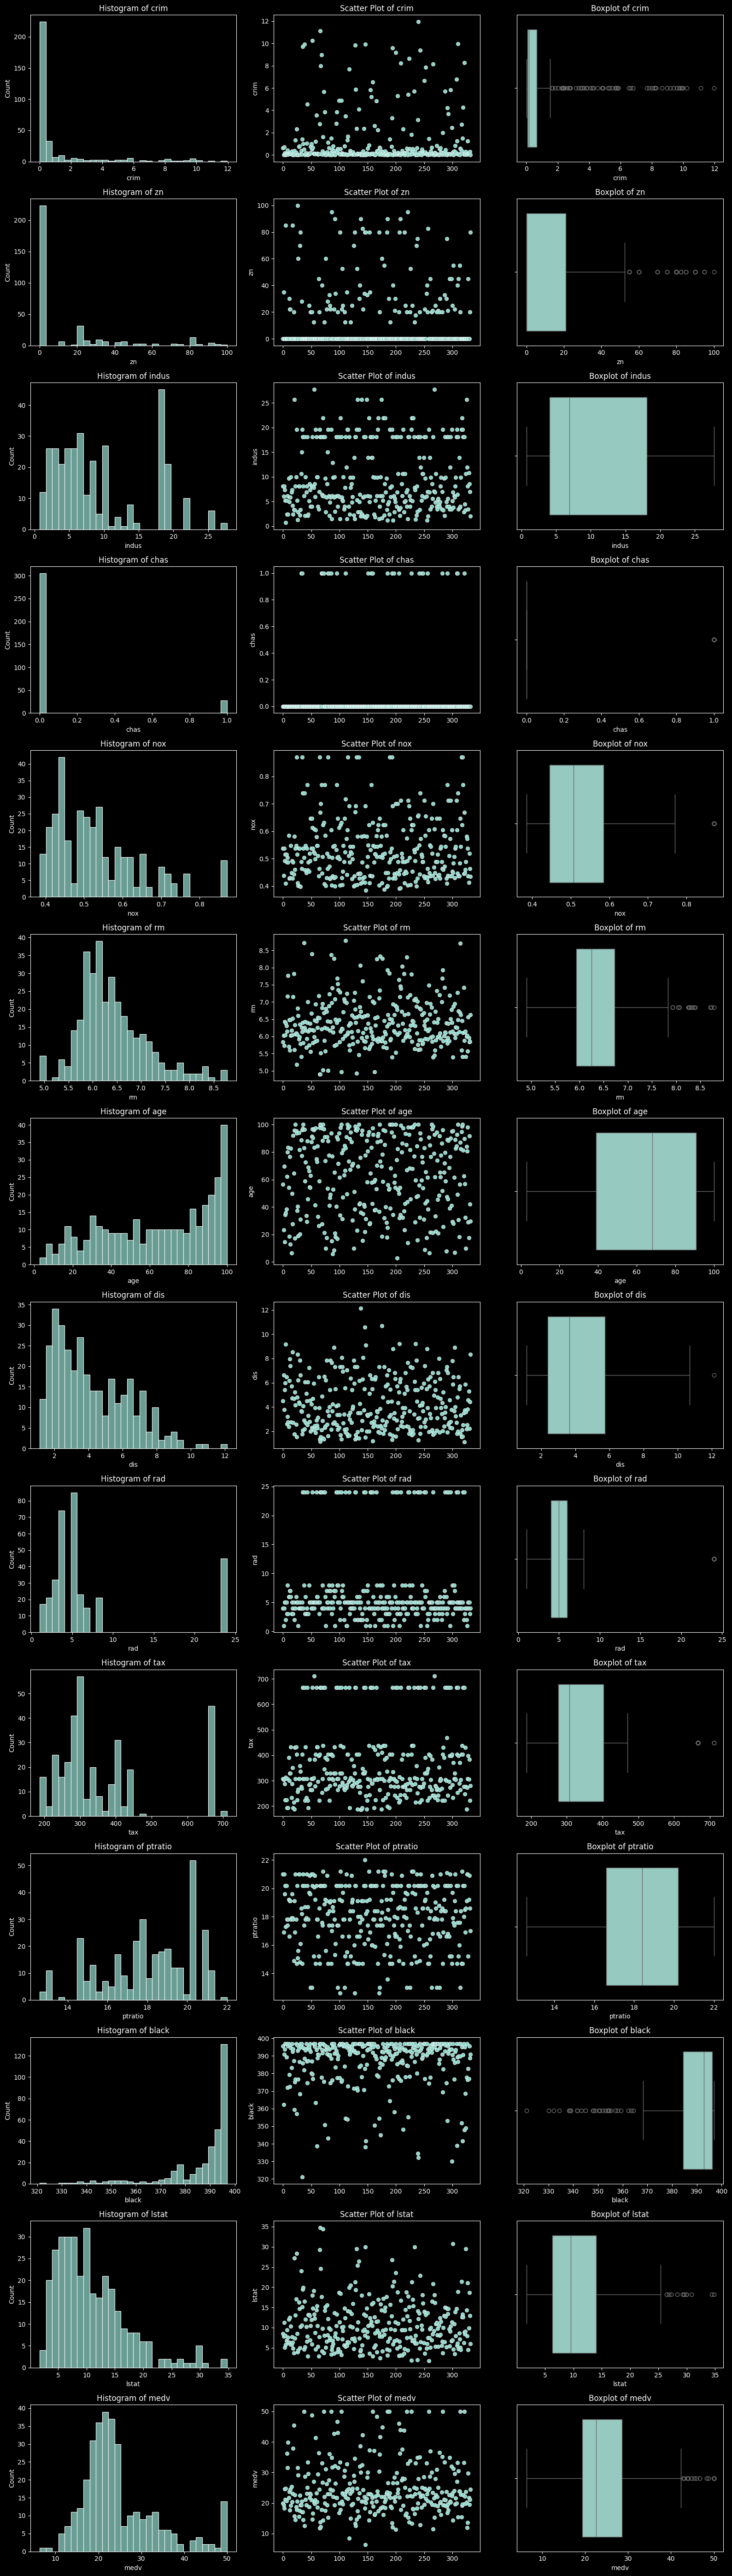

In [10]:
# Check distribution after handling
distribution_plot(df_train, variable)

## Multicollinear Check

In [15]:
# Calculating VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X_train = df_train.drop(columns='medv')
y_train = df_train[['medv']]

X_const = add_constant(X_train)
vif_df = pd.DataFrame([vif(X_const.values, i)
               for i in range(X_const.shape[1])],
              index=X_const.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,5.732566
2,zn,2.428250
3,indus,3.229731
4,chas,1.112141
5,nox,4.495035
6,rm,2.224569
7,age,2.794146
8,dis,3.746722
9,rad,7.942876
10,tax,5.641213


There are several features with high VIF scores:
1.   crim (moderate multicollinearity)
2.   nox (moderate multicollinearity)
3.   rad (moderate multicollinearity)
4.   tax (moderate multicollinearity)

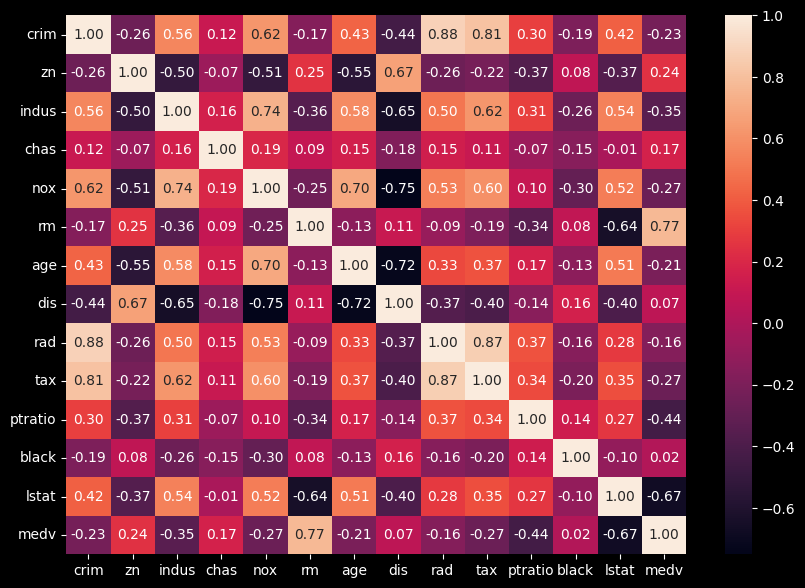

In [17]:
# Heatmap correlation
corr = df_train.corr()
plt.figure(figsize=(10,7))
plt.style.use('dark_background')
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

The features with very strong correlation (>= 0.80): crim-rad (0.88), crim-tax (0.81), and rad-tax (0.87). Therefore, we need to retain one of them, specifically the one with the highest correlation to the target variable.
*   retain tax
*   drop crim and rad


`Note`: Although the variables nox and dis have VIF scores greater than 4, their correlation with other variables is not considered very high/strong. Therefore, in this case, it is not necessary to drop either or both of these variables.

In [18]:
# Drop crim and rad columns
X_train = X_train.drop(columns=['crim', 'rad'])
X_test = X_test.drop(columns=['crim', 'rad'])

In [20]:
# Calculating VIF scores after drop
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X_const = add_constant(X_train)

vif_df = pd.DataFrame([vif(X_const.values, i)
               for i in range(X_const.shape[1])],
              index=X_const.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,zn,2.321065
2,indus,3.100212
3,chas,1.089404
4,nox,4.321379
5,rm,2.127379
6,age,2.777125
7,dis,3.713843
8,tax,2.190089
9,ptratio,1.695319
10,black,1.188898


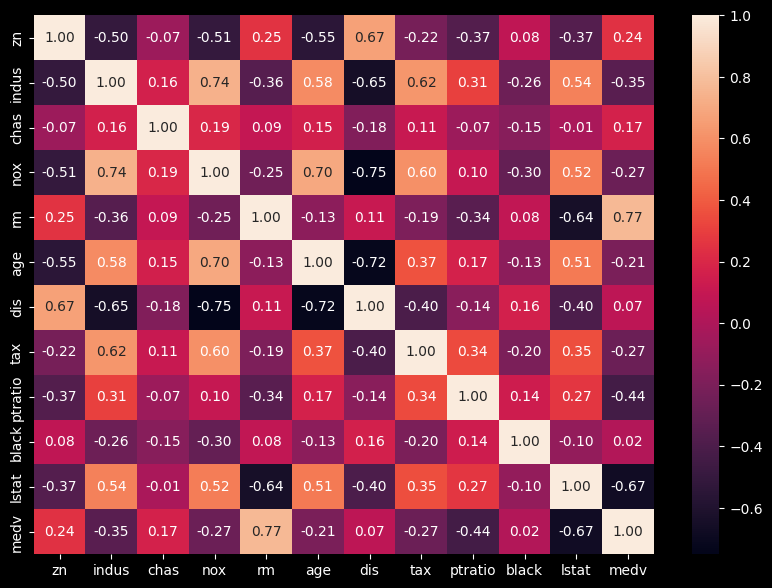

In [22]:
# Heatmap correlation after drop
df_train = pd.concat([X_train, y_train], axis=1)
corr = df_train.corr()

plt.figure(figsize=(10,7))
plt.style.use('dark_background')
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

# Linear Regression

In [23]:
from sklearn.preprocessing import StandardScaler

# Scaling X
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [24]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Training model
model_lr = LinearRegression()
model_lr.fit(X_train_std, y_train)

LinearRegression()

In [25]:
from sklearn.metrics import r2_score

y_predict_train_lr = model_lr.predict(X_train_std)
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train_lr)))

R-squared for training data is 0.7203638050639721


In [26]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train_lr = model_lr.predict(X_train_std)

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train_lr))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train_lr)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train_lr)))

RMSE for training data is 4.676179224563567
MAE for training data is 3.175889677722186
MAPE for training data is 0.13649770206844686


In [27]:
# Calculating error of Data Testing
y_predict_test_lr = model_lr.predict(X_test_std)
print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test_lr))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test_lr)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test_lr)))

RMSE for testing data is 5.326157293432736
MAE for testing data is 3.5354545133823603
MAPE for testing data is 0.19687271053406485


# Regularized Regression

## Ridge Regression

### Train Model

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Tuning alpha using Grid Search
alpha_values = np.arange(0.01, 10, 0.01)
ridge_cv = GridSearchCV(Ridge(random_state=42), param_grid={'alpha': alpha_values}, cv=5, scoring='neg_root_mean_squared_error')

# Train model
ridge_cv.fit(X_train_std, y_train.to_numpy())

# Best Model
print(f"The minimum RMSE is {-ridge_cv.cv_results_['mean_test_score'][ridge_cv.best_index_]:.6f} with the alpha = {ridge_cv.best_params_['alpha']:.2f} -> The best model")

The minimum RMSE is 4.909385 with the alpha = 9.99 -> The best model


### Coefficients

#### Interpretation

In [30]:
# Convert scaled beta to original beta
coef_ridge_unscaled = ridge_cv.best_estimator_.coef_ / scaler.scale_
intercept_ridge_unscaled = ridge_cv.best_estimator_.intercept_ - np.sum(coef_ridge_unscaled * scaler.mean_)

# Create a temporary DataFrame without the 'stability_status'
coef_ridge_temp = pd.DataFrame({
    'feature': ['intercept'] + X_train.columns.tolist(),
    'coef_final': [intercept_ridge_unscaled[0]] + list(coef_ridge_unscaled),
    'coef_std': [ridge_cv.best_estimator_.intercept_[0]] + list(ridge_cv.best_estimator_.coef_)})
coef_ridge_temp

,feature,coef_final,coef_std
0,intercept,19.244891,24.772072
1,zn,0.013970,0.346198
2,indus,0.012122,0.080257
3,chas,2.854592,0.792189
4,nox,-10.303518,-1.146046
5,rm,6.095224,4.216431
6,age,-0.017948,-0.507274
7,dis,-1.138597,-2.441562
8,tax,-0.001992,-0.278577
9,ptratio,-0.696239,-1.538049


**Standardized Coefficients (coef_std):**

Standardized coefficients (coef_std) help compare how different features affect changes in the median value of homes. Because the values have already been standardized, direct comparisons are valid. The smaller the absolute coefficient, the less impact the feature has on changes in the median home value.

**The established model:**


```
medv = 19.244891 + 0.013970*zn + 0.012122*indus + 2.854592*chas - ... - 0.436512*lstat
```

**Based on the equations above, we can conclude two points:**
1.   There are several factors that contribute to a decline in the median value of homes (medv), including:
 *   High levels of nitric oxides (gases usually produced from combustion processes, such as vehicle engines, power plants, or industrial activities).
 *   A high proportion of older homes (built before 1940).
 *   Long distances between homes and the five Boston employment centers.
 *   High property tax rates.
 *   An imbalanced pupil-teacher ratio (more pupils than teachers).
 *   Homes located in areas with a high proportion of Black residents.
 *   Homes located in areas with a high percentage of the population with low socio-economic status.
2.   Factors contributing to an increase in the median value of homes (medv) include:
 *   A higher percentage of land allocated for residential zones, indicating that the home is located in a neighborhood with many residential areas.
 *   A high percentage of land used for non-retail industrial businesses.
 *   Homes bordering the Charles River.
 *   Homes with a greater number of rooms.


**Interpretation of some variable and its impact:**
*   Every increase of 1 unit in the proportion of residential land zoned (zn) increases the median value of homes (medv) by 0.013970 thousand dollar.
*   Homes bordering the Charles River (chas = 1) have a median value of homes (medv) that is 2.854592 thousand dollar higher compared to homes that do not border the Charles River (chas = 0).
*   Every increase of 1 unit in the percentage of the population with low socio-economic status (lstat) decreases the median value of homes (medv) by 0.436512 thousand dollar.
*   etc.

#### Evaluation

In this study, bootstrap sampling was used alongside Ridge Regression to assess the stability and reliability of coefficient estimates. While Ridge reduces overfitting and handles multicollinearity, it does not naturally provide uncertainty estimates. By fitting the Ridge model on multiple bootstrap samples, we obtained distributions of each coefficient, allowing us to compute their mean, standard deviation, and confidence intervals. This helps identify which features have consistently strong effects and which ones are unstable or not significant. The combination of Ridge and bootstrap offers more robust and interpretable results.

In [31]:
# Bootstrap processing
np.random.seed(42)
n_bootstrap = 1000
alpha_ridge = ridge_cv.best_params_['alpha']

coefs = []
for _ in range(n_bootstrap):
    idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    X_boot = X_train_std[idx]
    y_boot = y_train.values[idx]
    model = Ridge(alpha=alpha_ridge)
    model.fit(X_boot, y_boot)
    coefs.append(model.coef_)
coefs = np.array(coefs)

ridge_bootstrap_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef_mean': coefs.mean(axis=0),
    '95% CI lower': np.percentile(coefs, 2.5, axis=0),
    '95% CI upper': np.percentile(coefs, 97.5, axis=0)})
ridge_bootstrap_df['ci_width'] = ridge_bootstrap_df['95% CI upper'] - ridge_bootstrap_df['95% CI lower']
ridge_bootstrap_df['ci_includes_zero'] = (ridge_bootstrap_df['95% CI lower'] < 0) & (ridge_bootstrap_df['95% CI upper'] > 0)
ridge_bootstrap_df['ci_includes_zero'] = ridge_bootstrap_df['ci_includes_zero'].apply(lambda x: '❌' if x else '✅')
ridge_bootstrap_df

,feature,coef_mean,95% CI lower,95% CI upper,ci_width,ci_includes_zero
0,zn,0.338671,-0.240098,0.954430,1.194528,❌
1,indus,0.081205,-0.621864,0.750163,1.372027,❌
2,chas,0.802118,-0.026171,1.671893,1.698065,❌
3,nox,-1.104336,-2.079784,-0.203888,1.875896,✅
4,rm,4.257807,2.750472,5.668305,2.917833,✅
5,age,-0.528942,-1.507681,0.542027,2.049708,❌
6,dis,-2.407021,-3.363388,-1.530607,1.832781,✅
7,tax,-0.327673,-1.251671,0.540255,1.791926,❌
8,ptratio,-1.536438,-2.169219,-0.887270,1.281949,✅
9,black,-0.173930,-0.949811,0.512507,1.462318,❌


In [33]:
# Merge tables
coef_ridge_df = coef_ridge_temp.drop(columns='coef_final').merge(ridge_bootstrap_df[['feature', 'coef_mean', 'ci_width', 'ci_includes_zero']], on='feature', how='left')

# Determining label features
def label_feature(row, threshold_ci_width=2.0, threshold_diff=1.0):
    ci_includes_zero = row['ci_includes_zero']
    coef_diff = abs(row['coef_mean'] - row['coef_std'])
    ci_width = row['ci_width']

    if (ci_includes_zero == '❌' and coef_diff <= threshold_diff and ci_width <= threshold_ci_width): return "✅ Stable & Significant"
    elif (ci_includes_zero == '✅' and (coef_diff <= threshold_diff and ci_width <= threshold_ci_width)): return "⚠️ Stable but Not Significant"
    elif (ci_includes_zero == '❌' and (coef_diff > threshold_diff or ci_width > threshold_ci_width)): return "⚠️ Significant but Unstable"
    else: return "❌ Not Significant and Unstable"

# Apply to table
coef_ridge_df['label_feature'] = coef_ridge_df.apply(label_feature, axis=1)
coef_ridge_df.drop(index=0)

,feature,coef_std,coef_mean,ci_width,ci_includes_zero,label_feature
1,zn,0.346198,0.338671,1.194528,❌,✅ Stable & Significant
2,indus,0.080257,0.081205,1.372027,❌,✅ Stable & Significant
3,chas,0.792189,0.802118,1.698065,❌,✅ Stable & Significant
4,nox,-1.146046,-1.104336,1.875896,✅,⚠️ Stable but Not Significant
5,rm,4.216431,4.257807,2.917833,✅,❌ Not Significant and Unstable
6,age,-0.507274,-0.528942,2.049708,❌,⚠️ Significant but Unstable
7,dis,-2.441562,-2.407021,1.832781,✅,⚠️ Stable but Not Significant
8,tax,-0.278577,-0.327673,1.791926,❌,✅ Stable & Significant
9,ptratio,-1.538049,-1.536438,1.281949,✅,⚠️ Stable but Not Significant
10,black,-0.169661,-0.173930,1.462318,❌,✅ Stable & Significant


**Label Description**


| Label | Description | Criteria |
|-------|-------------|----------|
| ✅ **Stable & Significant** | Coefficient is stable, significant, and can be interpreted with high confidence. | CI does **not** cross zero, **narrow CI**, and `coef_final ≈ coef_mean` |
| ⚠️ **Unstable or Not Significant** | Model is not consistent in estimating this feature’s effect. It varies across bootstrap samples. | `coef_final ≠ coef_mean` or **CI is very wide** or **CI crosses zero**|
| ❌ **Not Significant and Unstable** | Coefficient is not significant. Effect is unclear or negligible. | **CI crosses zero** and (`coef_final ≠ coef_mean` or **CI is very wide**) |

- `Significant coefficient`: means its confidence interval does not include zero, suggesting a consistent effect on the target variable.
- `Stable coefficient`: shows little variation across bootstrap samples, typically indicated by a narrow confidence interval and `coef_final ≈ coef_mean`

📌 Summary Based on Bootstrap Ridge Coefficient Analysis:
From the analysis of 12 features using Ridge regression and bootstrap sampling:

- 5 features were labeled as ✅ Stable & Significant (zn, indus, chas, tax, black).

- 4 features (nox, age, dis, ptratio) fell under ⚠️ Significant but Unstable or ⚠️ Stable but Not Significant.

- 2 features (rm, lstat) were ❌ Not Significant and Unstable.

This labeling helps identify which predictors are robust and interpretable, and which should be treated with caution or excluded from interpretation due to low reliability.

## LASSO Regression

### Train Model

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Tuning alpha using Grid Search
alpha_values = np.arange(0.01, 10, 0.01)
lasso_cv = GridSearchCV(Lasso(random_state=42), param_grid={'alpha': alpha_values}, cv=5, scoring='neg_root_mean_squared_error')

# Train model
lasso_cv.fit(X_train_std, y_train.to_numpy())

# Best Model
print(f"The minimum RMSE is {-lasso_cv.cv_results_['mean_test_score'][lasso_cv.best_index_]:.6f} with the alpha = {lasso_cv.best_params_['alpha']:.2f} -> The best model")

The minimum RMSE is 4.931688 with the alpha = 0.06 -> The best model


### Coefficients

#### Interpretation

In [36]:
# Convert scaled beta to original beta
coef_lasso_unscaled = lasso_cv.best_estimator_.coef_ / scaler.scale_
intercept_lasso_unscaled = lasso_cv.best_estimator_.intercept_ - np.sum(coef_lasso_unscaled * scaler.mean_)

coef_lasso_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coef_final': [intercept_lasso_unscaled[0]] + list(coef_lasso_unscaled),
    'coef_std':[lasso_cv.best_estimator_.intercept_[0]] + list(lasso_cv.best_estimator_.coef_)})
coef_lasso_df

,feature,coef_final,coef_std
0,intercept,16.403337,24.772072
1,zn,0.009228,0.228691
2,indus,0.000000,0.000000
3,chas,2.695911,0.748153
4,nox,-9.890042,-1.100056
5,rm,6.213662,4.298361
6,age,-0.015660,-0.442612
7,dis,-1.089563,-2.336416
8,tax,-0.001192,-0.166681
9,ptratio,-0.707306,-1.562498


**Notes**

The variables indus has coefficients of 0. This means that that variable is considered to has no significant influence on the median value of homes (medv) and, therefore, is excluded from the model. We will see how much this variable contributes to the target variable in the evaluation chapter.


**The established model:**


```
medv = 16.403337 + 0.009228*zn + 2.695911*chas - ... - 0.438154*lstat
```

**Based on the equations above, we can conclude two points:**
1.   There are several factors that contribute to a decline in the median value of homes (medv), including:
 *   High levels of nitric oxides (gases usually produced from combustion processes, such as vehicle engines, power plants, or industrial activities).
 *   A high proportion of older homes (built before 1940).
 *   Long distances between homes and the five Boston employment centers.
 *   High property tax rates.
 *   An imbalanced pupil-teacher ratio (more pupils than teachers).
 *   Homes located in areas with a high proportion of Black residents.
 *   Homes located in areas with a high percentage of the population with low socio-economic status.
2.   Factors contributing to an increase in the median value of homes (medv) include:
 *   A higher percentage of land allocated for residential zones, indicating that the home is located in a neighborhood with many residential areas.
 *   Homes bordering the Charles River.
 *   Homes with a greater number of rooms.

**Interpretation of each variable and its impact:**
*   Every increase of 1 unit in the proportion of residential land zoned (zn) increases the median value of homes (medv) by 0.009228 thousand dollar.
*   Homes bordering the Charles River (chas = 1) have a median value of homes (medv) that is 2.695911 thousand dollar higher compared to homes that do not border the Charles River (chas = 0).
*   Every increase of 1 unit in the percentage of the population with low socio-economic status (lstat) decreases the median value of homes (medv) by 0.438154 thousand dollar.
*   etc.

#### Evaluation

In [40]:
from sklearn.utils import resample

# Apply Bootstrap Sampling with Best Alpha
np.random.seed(42)
n_bootstraps = 1000
feature_counts = np.zeros(X_train_std.shape[1])
for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_train_std, y_train, replace=True)
    lasso = Lasso(alpha = lasso_cv.best_params_['alpha'])
    lasso.fit(X_sample, y_sample)
    feature_counts += (lasso.coef_ != 0)

feature_stability = pd.DataFrame({
    'Feature': X_train.columns,
    'Selection Frequency (%)': (feature_counts / n_bootstraps) * 100})

feature_stability.sort_values(by='Selection Frequency (%)', ascending=False)

,Feature,Selection Frequency (%)
10,lstat,100.0
6,dis,100.0
4,rm,100.0
8,ptratio,100.0
3,nox,97.6
2,chas,96.8
5,age,88.1
7,tax,85.6
9,black,84.7
0,zn,82.0


Insight 💡
- Based on the bootstrap results, several features were selected consistently across all samples, with `lstat, dis, rm, ptratio` appearing in 100% of iterations. This indicates they are the most stable and influential predictors in the model.
- Features like `chas, nox, age, black, tax, zn` also showed high selection frequencies (> 80%), suggesting potential importance with slightly less consistency.
- Meanwhile, `indus` variable has lower frequencies (< 75%), implying it may has weaker or less stable contributions. This is consistent with the feature selection performed by LASSO without bootstrapping, where `indus` variable has a coefficient of 0 or ≈0.

Overall, the bootstrap selection frequencies help identify features with strong and reliable predictive power.

# Diagnostic Study

## Ridge Regression

### R-Square

In [41]:
from sklearn.metrics import r2_score

y_predict_train_ridge = ridge_cv.predict(X_train_std)
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train_ridge)))

R-squared for training data is 0.719812022957118


The R-Square value in the Ridge Regression is `0.7532189248565029` or approximately `75.32%`. This indicates that the twelve independent variables/features included in the model are able to explain `75.32%` of the variability in the dependent variable (medv/median value of homes). The remaining `24.68%` is explained by other variables outside the model.

### Assumption Check

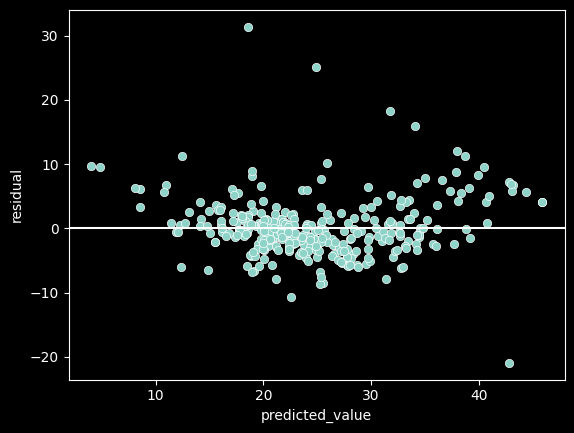

In [42]:
# Calculate residuals
residual = y_train.to_numpy()[:, 0] - y_predict_train_ridge

# Prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_ridge,
    'residual': residual})

# Residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption Checks:
*   Linear relationship: Fulfilled. The horizontal line at y=0 adequately represents the overall distribution of residual points.
*   Variance stability: Not fulfilled. Variance is more pronounced at the beginning and end of the data.
*   Independent residuals: Not fulfilled. The residual points appear to form a curved (non-linear) pattern.

### Model Evaluation

In [44]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train_ridge = ridge_cv.predict(X_train_std)

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train_ridge))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train_ridge)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train_ridge)))

RMSE for training data is 4.680790502516664
MAE for training data is 3.1659607820079936
MAPE for training data is 0.13562030429012967


In [46]:
# Calculating error of Data Testing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on test data
y_predict_test_ridge = ridge_cv.predict(X_test_std)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test_ridge))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test_ridge)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test_ridge)))

RMSE for testing data is 5.27596334971123
MAE for testing data is 3.466602173746504
MAPE for testing data is 0.19237999600245423


The evaluation results of the model indicate that the RMSE, MAE, and MAPE values for the training data and testing data do not show significant differences (only slightly lower), suggesting that the selected model has been proven to be well-suited.

## LASSO Regression

### R-Square

In [47]:
from sklearn.metrics import r2_score

y_predict_train_lasso = lasso_cv.predict(X_train_std)
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train_lasso)))

R-squared for training data is 0.7194440312556014


The R-Square value in the LASSO Regression is `0.7525031291642488` or approximately `75.25%`. This indicates that the nine independent variables/features included in the model are able to explain `75.25%` of the variability in the dependent variable (medv/median value of homes). The remaining `24.75%` is explained by other variables outside the model.

### Assumption Check

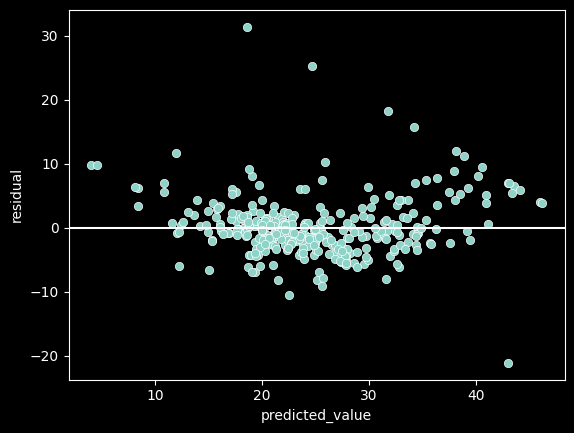

In [48]:
# Calculate residuals
residual = y_train.to_numpy()[:, 0] - y_predict_train_lasso

# Prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_lasso,
    'residual': residual})

# Residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption Checks:
*   Linear relationship: Not fulfilled. The residual points are not evenly distributed around the y=0 line (more data below the y=0 line).
*   Variance stability: Not fulfilled. Variance is more pronounced at the beginning and end of the data.
*   Independent residuals: Not fulfilled. The residual points appear to form a curved (non-linear) pattern.

### Model Evaluation

In [49]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train_lasso = lasso_cv.predict(X_train_std)

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train_lasso))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train_lasso)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train_lasso)))

RMSE for training data is 4.683863308997356
MAE for training data is 3.160254504998971
MAPE for training data is 0.1357527785661204


In [50]:
# Calculating error of Data Testing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on test data
y_predict_test_lasso = lasso_cv.predict(X_test_std)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test_lasso))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test_lasso)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test_lasso)))

RMSE for testing data is 5.250132705934452
MAE for testing data is 3.442763029706269
MAPE for testing data is 0.1905747814658834


The evaluation results of the model indicate that the RMSE, MAE, and MAPE values for the training data and testing data do not show significant differences, and are even lower for the testing data, suggesting that the selected model has been proven to be well-suited.

# Conclusion

## Summary

In [61]:
metric_evaluation = {
    "Model": ["Linear Regression", "Ridge Regression", "LASSO Regression"],
    "R² (Train)": [0.7204, 0.7198, 0.7194],
    "RMSE (Train)": [4.6762, 4.6808, 4.6839],
    "MAE (Train)": [3.1759, 3.1660, 3.1603],
    "MAPE (Train)": [0.1365, 0.1356, 0.1358],
    "RMSE (Test)": [5.3262, 5.2760, 5.2501],
    "MAE (Test)": [3.5355, 3.4666, 3.4428],
    "MAPE (Test)": [0.1969, 0.1924, 0.1906],
}
metric_evaluation = pd.DataFrame(metric_evaluation)

# % RMSE Change
metric_evaluation["Delta RMSE (%)"] = ((metric_evaluation["RMSE (Test)"] - metric_evaluation["RMSE (Train)"]) / metric_evaluation["RMSE (Train)"] * 100).round(2)
metric_evaluation["Delta MAE (%)"] = ((metric_evaluation["MAE (Test)"] - metric_evaluation["MAE (Train)"]) / metric_evaluation["MAE (Train)"] * 100).round(2)
metric_evaluation["Delta MAPE (%)"] = ((metric_evaluation["MAPE (Test)"] - metric_evaluation["MAPE (Train)"]) / metric_evaluation["MAPE (Train)"] * 100).round(2)
metric_evaluation

,Model,R² (Train),RMSE (Train),MAE (Train),MAPE (Train),RMSE (Test),MAE (Test),MAPE (Test),Delta RMSE (%),Delta MAE (%),Delta MAPE (%)
0,Linear Regression,0.7204,4.6762,3.1759,0.1365,5.3262,3.5355,0.1969,13.90,11.32,44.25
1,Ridge Regression,0.7198,4.6808,3.1660,0.1356,5.2760,3.4666,0.1924,12.72,9.49,41.89
2,LASSO Regression,0.7194,4.6839,3.1603,0.1358,5.2501,3.4428,0.1906,12.09,8.94,40.35


💡 Conclusions That Can Be Drawn:
1. LASSO is the best model if we want to minimize error on test data and maintain stability between training and testing.
2. Linear Regression shows some overfitting (higher R² in training, but greater performance drop on testing).
3. Ridge is in the middle, with slightly worse performance than LASSO, but more stable than Linear Regression in terms of overfitting.



🎯 So:
1. If the main goal is stability and generalization, then LASSO is the best choice.
2. If a highly accurate training model is needed (even with potential overfitting), Linear Regression can be chosen, although LASSO is better in terms of testing error.
3. Ridge provides a balance but is slightly worse than LASSO on almost all error metrics on testing.

## Research POV

**📌 Recommendations from a Research Perspective**

1. **Prioritize Stable & Significant Predictors in Modeling**  
   Based on LASSO regression, variables such as `lstat, dis, rm, ptratio, chas, nox, age, black, tax, zn` were found to be statistically significant and stable across bootstrap samples. These features consistently influenced the target variable (`medv`) with narrow confidence intervals and minimal coefficient variability.  
   ➤ *Recommendation:* Future regression models or predictive frameworks should prioritize these features for improved accuracy and interpretability.

2. **Deprioritize Non-Significant Variables**  
   Variables such as `indus` has lower selection frequencies in bootstrap (< 75%), implying it may has weaker or less stable contributions. This is consistent with the feature selection performed by LASSO without bootstrapping, where `indus` variable has a coefficient of 0 or ≈0.  
   ➤ *Recommendation:* Consider removing or regularizing these variables more strongly in future models to reduce complexity without sacrificing performance.

3. **Alternative Model Exploration**  
   The three models exhibit an increase in error metrics (RMSE, MAE, MAPE), particularly MAPE, indicating that the models are still not performing optimally on the test data.  
   ➤ *Recommendation:*
   
   - Consider exploring other models, such as ElasticNet (a combination of LASSO and Ridge) or non-linear models like Random Forest Regressor or Gradient Boosting, which are more resistant to overfitting.
   
   - Gathering More Data:
      1. If possible, consider collecting additional data relevant to the problem you are addressing. If data is limited within a specific domain, this is the best solution.
      2. Data Augmentation: If acquiring new data is challenging, data augmentation can be used. This technique modifies existing data to create new variations, such as: Noise Injection (Adding slight noise to the data to enhance variability) or Bootstrapping (Randomly generating subsets from the existing dataset)





## Business POV

**💼 Business Recommendations Based on LASSO Bootstrap Analysis**

1. **Focus Urban Planning on Environmental and Educational Quality**  
   Features like **nox (air pollution)** and **ptratio (pupil-teacher ratio)** were found to have strong, consistent negative impacts on housing prices.  
   ➤ *Action:* Policymakers and urban developers should invest in cleaner environments and better education systems to support higher property values.

2. **Promote Housing Near Employment Centers**  
   The variable **dis (distance to employment centers)** showed a stable negative relationship with home prices, indicating that proximity to jobs remains a key value driver.  
   ➤ *Action:* Encourage housing development near business districts and improve transportation to reduce commuting times.

3. **Preserve and Leverage Natural Amenities**  
   The **chas** variable (whether a property is near the Charles River) was a strong positive predictor of value.  
   ➤ *Action:* Maintain and market natural or scenic features like rivers and parks to increase real estate desirability.

4. **Highlight Home Quality in Marketing**  
   Although **rm (average number of rooms)** showed some uncertainty, its consistent positive impact suggests that larger homes are generally more valued.  
   ➤ *Action:* Emphasize spaciousness and home upgrades in property listings and renovations.

5. **Be Cautious with Taxes in Messaging**  
   Variables like **tax** was not consistently significant in the model, suggesting their impact may be nuanced or dependent on other factors.  
   ➤ *Action:* Don’t overemphasize tax rates in pricing strategy—focus instead on holistic neighborhood benefits.

6. **Use Data-Driven Insights in Real Estate Strategy**  
   The combination of Ridge regression with bootstrap analysis provides a more reliable view of what drives housing prices.  
   ➤ *Action:* Real estate professionals and investors should leverage such robust statistical techniques to guide investment decisions and market analysis.